In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

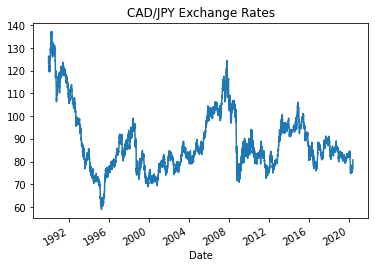

In [6]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df['Price'].plot(title='CAD/JPY Exchange Rates')

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** Short term we can see a strong downtrend in the price of CAD/JPY from 1990 to 1995 from a high of ~138 to a low of ~60, followed by a recovery to ~100 and with a correction back to ~70 in 1998. From here we saw a rise up to 209, followed by a sharp fall. Since then price has more stability, with a degree of noise. Long Term the pattern is less clear, while there is a clear downtrend from 1990 until 1995, price movements have been very noisy, more or less cented around a similar mean.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [7]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [37]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
df = cad_jpy_df
df["noise"] = ts_noise
df["trend"] = ts_trend
df = df.drop(columns = ['Open','High','Low'])


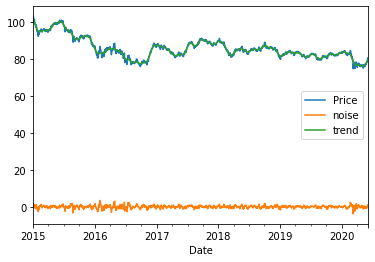

In [39]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
df_2015 = df.loc['2015-01-01':]
df_2015.plot()

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Noise profile both short term and long term have no clear trend. We see a downtrend of both price and trend from ~100 in 2015 to ~75 by 2017. From here there is a rapid rise to ~90 and price continues to range with no clear trend. Long term however there doesn't appear to be any trend

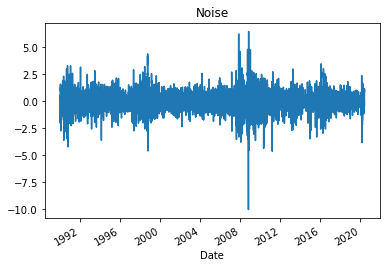

In [41]:
# Plot the Settle Noise
df['noise'].plot(title='Noise')

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [46]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [49]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))
# Fit the model and assign it to a variable called results
results = model.fit()

In [50]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sat, 23 Jan 2021   AIC                          19513.955
Time:                        16:22:55   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8548      0.164     -5.201      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.031      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1693           +0.0000j           42.1693            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

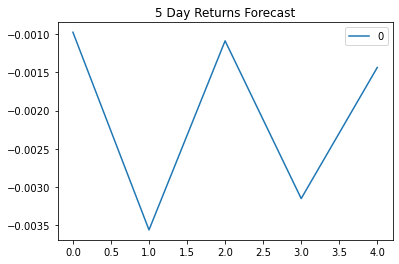

In [51]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** Th P value isn't statistically significant Const P>|z| = 0.807

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [55]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model_2 = ARIMA(returns.values, order=(5, 1, 1))

# Fit the model
results_2 = model_2.fit()

In [57]:
# Output model summary results:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7927
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -9754.028
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sat, 23 Jan 2021   AIC                          19524.056
Time:                        16:37:21   BIC                          19579.880
Sample:                             1   HQIC                         19543.173
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.756e-06   3.83e-06      0.719      0.472   -4.75e-06    1.03e-05
ar.L1.D.y     -0.0303      0.011     -2.701      0.007      -0.052      -0.008
ar.L2.D.y     -0.0026      0.011     -0.232      0.816      -0.025       0.019
ar.L3.D.y     -0.0102      0.011     -0.905      0.365      -0.032       0.012
ar.L4.D.y      0.0015      0.011      0.133      0.894      -0.021       0.024
ar.L5.D.y     -0.0188      0.011     -1.676      0.094      -0.041       0.003
ma.L1.D.y     -1.0000      0.000  -2488.070      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1266           -0.0000j            2.1266           -0.5000
AR.2            1.7743           -1.3629j            2.2374           -0.1042
AR.3            1.7743           +1.3629j            2.2374            0.1042
AR.4           -0.6712           -2.1306j            2.2338           -0.2986
AR.5           -0.6712           +2.1306j            2.2338            0.2986
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

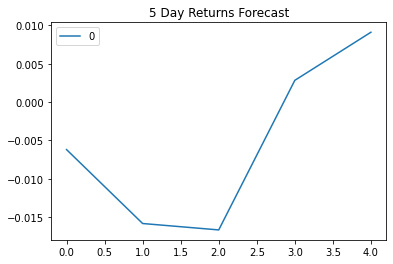

In [60]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results_2.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The price will likely drop in the next 3 days, before experiencing some appreication on the 4th and final day

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [65]:
from arch import arch_model

In [66]:
# Estimate a GARCH model:
model_3 = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results_3 = model_3.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 569545243.4284524
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838552966728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11769.086094978014
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.350185312931
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.366479560163
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.111921464748
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027336222945
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.02203125968
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021014202204
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020776838068
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764888566
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.02076489123
Optimization terminated successfully    (Exit mode 0)
          

In [69]:
# Summarize the model results
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Sat, Jan 23 2021   Df Residuals:                     7924
Time:                        17:33:01   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [70]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [72]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = results_3.forecast(start='2020-06-04',horizon=forecast_horizon)

In [73]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566035,12.573725,12.581308,12.588786,12.596161


In [74]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566035
h.2,12.573725
h.3,12.581308
h.4,12.588786
h.5,12.596161


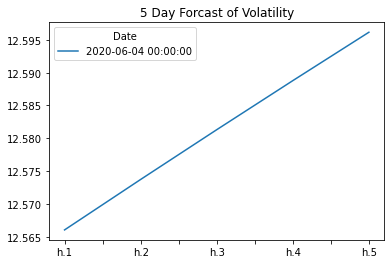

In [75]:
# Plot the final forecast
final.plot(title="5 Day Forcast of Volatility")

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** volatility is likely to increase in the next 5 days

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    None of our predictions are statistically sinificant so we can't be confident about the future price movement. Therefore I wouldn't buy Yen, even still our time series models have a tendancy to predict a drop in the Yen, so even if they where stats significant this is likely a bad investment.

2. Is the risk of the yen expected to increase or decrease?

    The Risk of the yen is expected to increase across the next 5 days based on our GARCH model as we see volatitily going up, however alpha(2) is not stat significant so we can't be confident with this prediction.

3. Based on the model evaluation, would you feel confident in using these models for trading?

    Once more the ARMA or ARIMA models are not stat. significant therefore we can't be very confident about these predictions. The Garch model performs better but still not perfect so could provide some use, but shouldn't be used with a high degree of confidence.